In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import imageio
from tqdm.notebook import tqdm

import sys
sys.path.append("../")
from envs.environment import DeliveryEnvironment
from agents.main_agents import QAgent, SARSAgent, DoubleQAgent, DelayedQAgent

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def run_episode(env, agent, verbose = 1):

    s = env.reset()
    agent.reset_memory()

    max_step = env.n_stops
    
    t_ = 0 # This is for the process of DelayedQAgent only
    episode_reward = 0
    
    i = 1
    while i < max_step + 1:

        agent.remember_state(s)
        a = agent.act(s)
        s_next, r, done = env.step(a)
        if agent.__class__.__name__ == 'SARSAgent':
            a_next = agent.act(s_next)
        r = -1 * r
        
        if verbose: print(s_next, r, done)

        if agent.__class__.__name__ == 'DelayedQAgent':
        
            if agent.LEARN[s,a] == 1:
                agent.U[s,a] = agent.U[s,a] + r + agent.gamma * np.max(agent.Q[s_next,a])
                agent.l[s,a] = agent.l[s,a] + 1
                
                if agent.l[s,a] == agent.m:
                    if agent.Q[s,a] - (agent.U[s,a] / agent.m) >= 2 * agent.epsilon:
                        agent.Q[s,a] = (agent.U[s,a] / agent.m) + agent.epsilon
                        t_ = i
                    elif agent.t[s,a] >= t_:
                        agent.LEARN[s,a] = 0
                    
                    agent.t[s,a] = i
                    agent.U[s,a] = 0
                    agent.l[s,a] = 0

            elif agent.t[s,a] < t_:
                agent.LEARN[s,a] = 1
        
        elif agent.__class__.__name__ == 'SARSAgent':
            agent.train(s, a, r, s_next, a_next)
        
        elif agent.__class__.__name__ in ['QAgent', 'DoubleQAgent']:
            agent.train(s, a, r, s_next)

        if agent.__class__.__name__ in ['QAgent', 'SARSAgent', 'DoubleQAgent']:
            if agent.epsilon > agent.epsilon_min:
                # agent.epsilon *= agent.epsilon_decay
                agent.epsilon = agent.epsilon**i
                # agent.epsilon = -(i/max_step)**6 + 1
                # agent.epsilon = 1 - i/max_step
        
        # Update the caches
        episode_reward += r
        s = s_next
        if agent.__class__.__name__ == 'SARSAgent':
            a = a_next
        
        # If the episode is terminated
        i += 1
        if done:
            break
            
    return env, agent, episode_reward

In [3]:
def run_n_episodes(env, agent, name = "training.gif", n_episodes = 2000, render_each = 10, duration = 100):

    # Store the rewards
    best_solution = None
    best_fitness = float('-inf')
    rewards = []
    imgs = []

    # Experience replay
    for i in tqdm(range(n_episodes)):

        # Run the episode
        env, agent, episode_reward = run_episode(env, agent, verbose = 0)
        rewards.append(episode_reward)
        if episode_reward > best_fitness:
            best_fitness = episode_reward
            best_solution = agent.states_memory
        
        if i % render_each == 0:
            img = env.render(return_img = True)
            imgs.append(img)

    # Show rewards
    plt.figure(figsize = (15, 3))
    plt.title("Rewards over training")
    plt.plot(rewards)
    plt.show()

    # Save imgs as gif
    # imageio.mimsave(name, imgs, duration = duration)

    return env, agent, best_fitness, best_solution

In [4]:
df = pd.read_csv("master.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233 entries, 0 to 2232
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   2233 non-null   int64  
 1   lat     2233 non-null   float64
 2   lng     2233 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 52.5 KB


(5, 2)
Initialized Delivery Environment with 5 random stops
Target metric for optimization is haversine_distance


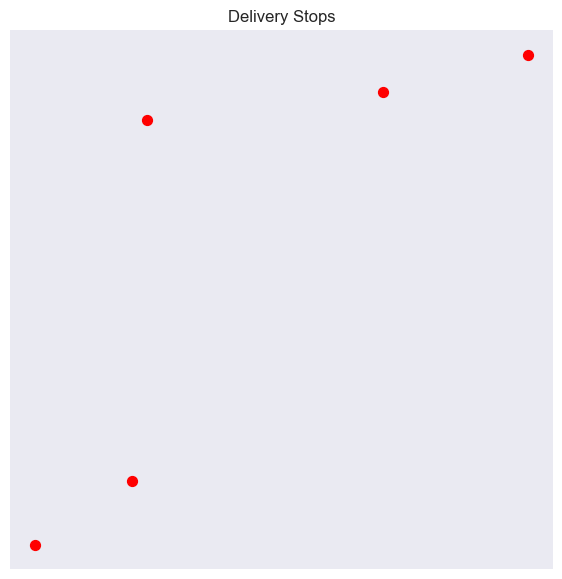

  0%|          | 0/2000 [00:00<?, ?it/s]

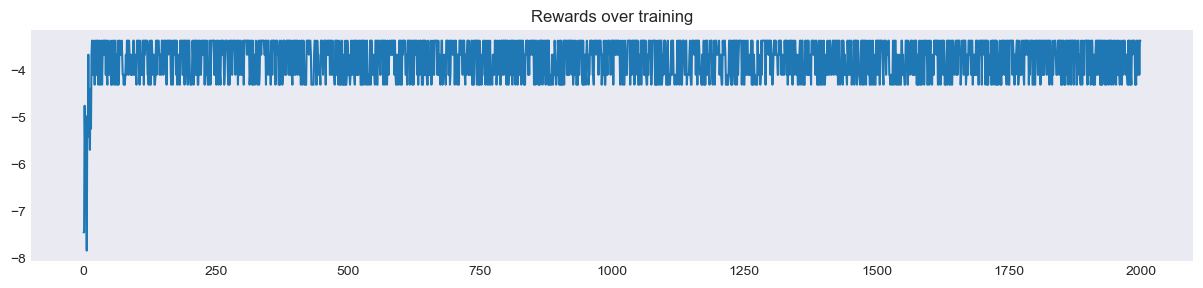

best_fitness: -3.377773428564811
best_fitness: [4, 3, 1, 2, '...', 4, 3, 1, 2] 
 ---------------------------------
(10, 2)
Initialized Delivery Environment with 10 random stops
Target metric for optimization is haversine_distance


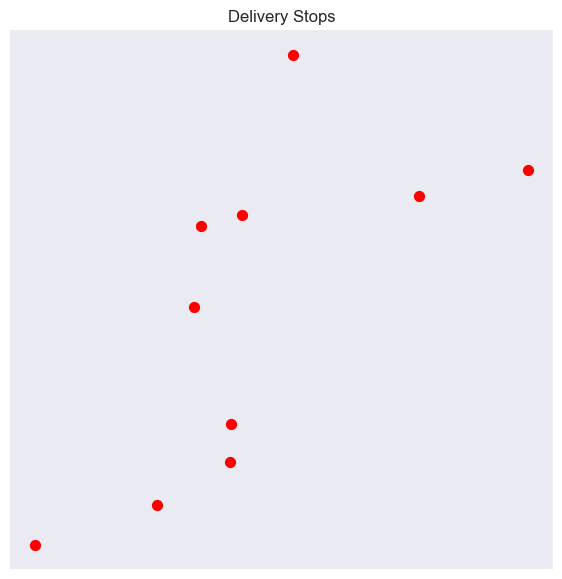

  0%|          | 0/2000 [00:00<?, ?it/s]

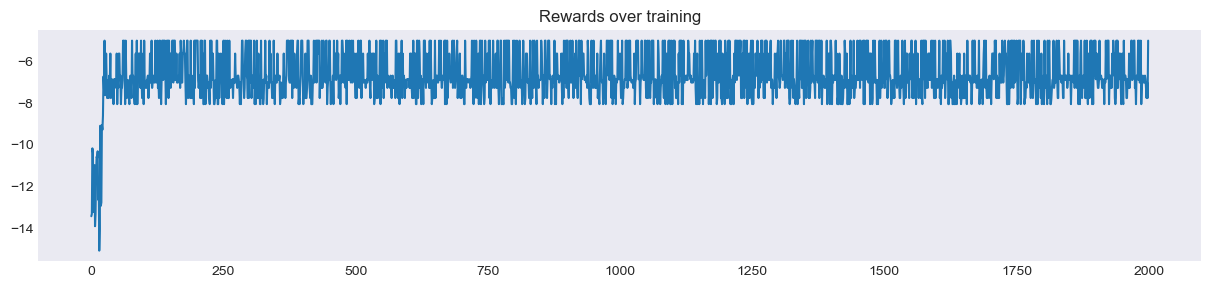

best_fitness: -5.023681281952384
best_fitness: [8, 4, 3, 9, 7, '...', 7, 6, 1, 5, 2] 
 ---------------------------------


In [5]:
# for i in [5, 10, 50, 100, 200, 500, 1000]:
for i in [5, 10]:
    data = df[['lat', 'lng']].head(i).to_numpy()
    print(data.shape)

    num_stops = data.shape[0]
    env = DeliveryEnvironment(data = data, n_stops = num_stops, method = "haversine_distance")
    agent = DelayedQAgent(env.observation_space, env.action_space)

    env, agent, best_fitness, best_solution = run_n_episodes(env, agent, "training_{}_stops.gif".format(num_stops))
    print('best_fitness:', best_fitness)
    print('best_fitness:', best_solution[:5] + ['...'] + best_solution[-5:], '\n', '---------------------------------')

In [6]:
agent.__class__.__name__

'DelayedQAgent'

# Visualize Q

In [7]:
import plotly.graph_objects as go
import plotly.express as px

In [8]:
x = [i for i in range(0, agent.states_size)]
y = [i for i in range(0, agent.actions_size)]

fig = go.Figure(
    go.Surface(
        contours = {
            "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
            "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
        },
        x = x, y = y,
        z = agent.Q,
        surfacecolor = agent.Q
    )
)

fig.update_layout(
    # title = 'Q values',
    width = 1000, height = 800,
    scene = {
        "xaxis": {"nticks": 20},
        "aspectratio": {"x": 1, "y": 1, "z": 1}
    }
)


fig.update_traces(
    contours_z = dict(
        show = True, usecolormap = True,
        highlightcolor = "limegreen",
        project_z = True
    )
)

fig.show()